# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

#NLP
#from pymystem3 import Mystem

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

import re

import time 

import random 
from sklearn.utils import shuffle

pd.set_option('display.max_columns', 40) #макс кол-во колонок в выводимых данных 
pd.set_option('display.max_rows', 20) #макс кол-во строк в выводимых данных
pd.set_option('display.width', 80) #макс кол-во символов в строке
import warnings
warnings.simplefilter('ignore')
pd.options.mode.chained_assignment = None

rs=7777777
sample_size=10_000

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pavlova\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
start_time = time.time()

In [3]:
try: 
    df=pd.read_csv('/datasets/toxic_comments.csv')
except: 
    df=pd.read_csv('datasets/toxic_comments.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Тексты / комментарии англоязычные.

In [6]:
df.toxic.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Видим дисбаланс классов. Только 11% комментариев "токсичные". Это хорошо, но не для обучения модели. Возможно, позже сделаем ресемплинг, а для логистической регрессии установим class_weight=balanced.

Разобьем текст на токены, проведем очистку и лемматизацию

In [7]:
m = WordNetLemmatizer()

In [8]:
def lemmatize_text(text):
    lemm_text = "".join(m.lemmatize(text.lower()))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

In [9]:
%%time
df['lemm_text'] = df['text'].apply(lemmatize_text)

Wall time: 9.21 s


In [10]:
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


In [11]:
df.shape

(159571, 3)

In [12]:
df = df.drop(['text'], axis=1)
del m

In [13]:
df.head()

,toxic,lemm_text
0,0,explanation why the edits made under my userna...
1,0,d aww he matches this background colour i m se...
2,0,hey man i m really not trying to edit war it s...
3,0,more i can t make any real suggestions on impr...
4,0,you sir are my hero any chance you remember wh...


Разделим выборку на обучающую, валидационную и тестовую в пропорции 60-20-20%

In [14]:
target = df['toxic']
features = df.drop(['toxic'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=rs)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=rs)

In [15]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pavlova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [17]:
features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values.astype('U'))
features_valid = count_tf_idf.transform(features_valid['lemm_text'].values.astype('U'))
features_test = count_tf_idf.transform(features_test['lemm_text'].values.astype('U'))

In [18]:
display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)

(95742, 125946)

(31914, 125946)

(31915, 125946)

In [19]:
cv_counts = 3

F1 на кросс-валидации:

In [20]:
classificator = LogisticRegression()
train_f1 = cross_val_score(classificator, features_train, target_train, cv=cv_counts, scoring='f1').mean()
train_f1

0.6795812203255008

F1 на кросс-валидации с балансированными классами:

In [21]:
classificator = LogisticRegression(class_weight='balanced', random_state=rs)
train_f1_balanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
train_f1_balanced

0.7501914961477499

Прирост F1-меры: 

In [22]:
train_f1_balanced - train_f1

0.0706102758222491

ROC кривая:

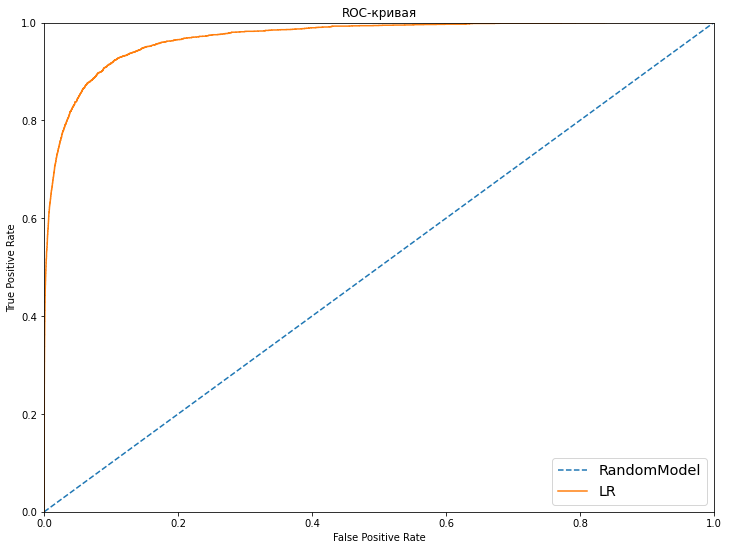

In [23]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

classificator = LogisticRegression(class_weight='balanced', random_state=rs)
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

На этапе обработки данных перевели текст при помощи nltk и TfidfVectorizer в числовые матрицы. 

Примерно 11% комментариев токсичны, пропусков нет. 

На тестировании лучшие F1 и AUC-ROC у классификатора, где учтен баланс классов. 

Перейдем к этапу работы с моделями ML.

## Обучение

Используем следующие модели:

- LogisticRegression
- SGDClassifier
- CatBoostClassifier

### Dummy Classifier

Для проверки остальных моделей посмотрим, что покажет Dummy Classifier

In [24]:
dummy = DummyClassifier(strategy="constant", constant=1, random_state=rs)
dummy.fit(features_train, target_train)
f1_score(target_train, dummy.predict(target_train))

0.18388406236958915

F1 при валидации:

In [25]:
f1_score(target_valid, dummy.predict(target_valid))

0.18737398120012494

Ожидаемо низкая мера F1. 

Напишем функицию для вывода F1 и матрицы ошибок обученной модели на тестовых данных и перейдем к моделям.

In [26]:
def model_report(fitted_model, feature, target):

    pred = fitted_model.predict(feature)
    conf_matrix = confusion_matrix(target, pred)
    
    print('f1_score = {:.3}'.format(f1_score(target, pred)))
    
    plt.figure(figsize=(4,4))
    sns.heatmap(conf_matrix,annot=True,cmap="Blues",fmt="d",cbar=False)
    plt.title('Confusion matrix')

### LogisticRegression

Напишем функцию для поиска и вывода на экран лучших параметров модели с помощью GridSearchCV

In [27]:
def grid_search(model, params, features, target):
    search = GridSearchCV(model, params, verbose=1, cv=5, scoring='f1', n_jobs=-1)
    search.fit(features, target)
    print(search.best_score_)
    print(search.best_params_)  

In [28]:
%%time
lr = LogisticRegression(class_weight='balanced', random_state=rs)
lr_params = dict(C = [0.1,1,10,100], 
                 tol = [1e-03, 1e-04, 1e-05])
grid_search(lr, lr_params, features_train, target_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.7689516385003101
{'C': 10, 'tol': 0.001}
Wall time: 2min 21s


In [29]:
lr_final = LogisticRegression(C=10, tol=0.001, class_weight='balanced', random_state=rs)
lr_final.fit(features_train, target_train)
f1_score(target_train, lr_final.predict(features_train))

0.931112501805228

In [30]:
F1_LR_valid = f1_score(target_valid, lr_final.predict(features_valid))
F1_LR_valid

f1_score = 0.76


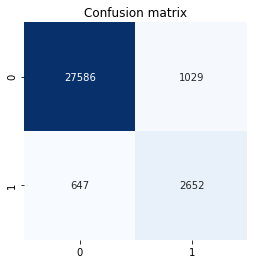

In [31]:
model_report(lr_final, features_valid, target_valid)

### SGDClassifier

In [32]:
%%time

classificator = SGDClassifier()
hyperparams = [
    {'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state': [rs]}
]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_SGDC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 7777777}

Grid scores on development set:

0.596912 for {'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 7777777}
0.435298 for {'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 7777777}
0.715465 for {'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 7777777}
0.621234 for {'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'random_state': 7777777}
0.448906 for {'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'random_state': 7777777}
0.718198 for {'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'random_state': 7777777}
0.000000 for {'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'hinge', 'random_state': 7777777}
0.000000 for {'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'log', 'rand

In [33]:
%%time
classificator_SGD = SGDClassifier(random_state=rs)
classificator_SGD.set_params(**SGDC_best_params)
classificator_SGD.fit(features_train, target_train)
target_predict = classificator_SGD.predict(features_valid)
cv_f1_SGDC

Wall time: 307 ms


0.7276976335146129

F1 на валидации

In [34]:
valid_f1_SGDC = f1_score(target_valid, target_predict)
valid_f1_SGDC

0.720640238228178

### CatBoostClassifier

In [35]:
%%time

classificator_cbc = CatBoostClassifier(verbose=False, iterations=200, random_state=rs)
classificator_cbc.fit(features_train, target_train)
target_predict = classificator_cbc.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator_cbc,
                                         features_train, 
                                         target_train, 
                                         cv=cv_counts, 
                                         scoring='f1', n_jobs=-1).mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
cv_f1_CBC

Wall time: 22min 33s


0.7263501377287286

F1 на валидации

In [36]:
valid_f1_CBC

0.7293354943273905

### Тестирование моделей

__LogisticRegression__

In [37]:
F1_LR_test = f1_score(target_test, lr_final.predict(features_test))
F1_LR_test

0.767962308598351

f1_score = 0.768


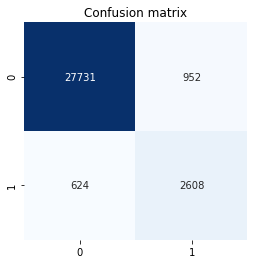

In [46]:
model_report(lr_final, features_test, target_test)

__SGDClassifier__

In [38]:
test_f1_SGDC = f1_score(target_test, classificator_SGD.predict(features_test))
test_f1_SGDC

0.7286441636809354

f1_score = 0.729


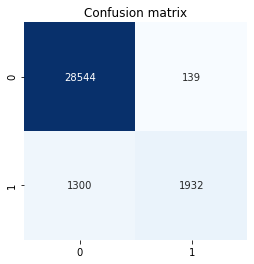

In [47]:
model_report(classificator_SGD, features_test, target_test)

__Catboost__

In [39]:
test_f1_CBC = f1_score(target_test, classificator_cbc.predict(features_test))
test_f1_CBC

0.745262390670554

f1_score = 0.745


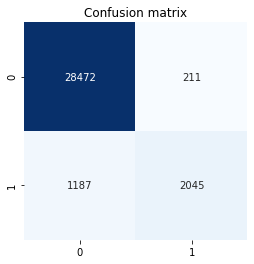

In [48]:
model_report(classificator_cbc, features_test, target_test)

### Выбор модели

Создадим таблицу из полученных значений F1 при сравнении моделей.

In [40]:
f1_results = {
    'model_name':pd.Series(['LogReg','SGD','CatBoost']),
    'f1_val_nltk':pd.Series([F1_LR_valid, valid_f1_SGDC, valid_f1_CBC]),
    'f1_test_nltk':pd.Series([F1_LR_test, test_f1_SGDC, test_f1_CBC])
}

f1_df = pd.DataFrame(f1_results)

In [41]:
f1_df

,model_name,f1_val_nltk,f1_test_nltk
0,LogReg,0.759885,0.767962
1,SGD,0.720640,0.728644
2,CatBoost,0.729335,0.745262


__Сравнение ROC-кривых и других метрик__

Метрики LogisticRegression
ROC AUC: 0.9662700331258416
F1: 0.767962308598351
Precision: 0.7325842696629213
Recall: 0.806930693069307
Accuracy: 0.9506188312705625

Метрики SGD Classifier
ROC AUC: 0.968700697630949
F1: 0.7286441636809354
Precision: 0.932882665379044
Recall: 0.5977722772277227
Accuracy: 0.954911483628388

Метрики CatBoostClassifier
ROC AUC: 0.9526184439121665
F1: 0.745262390670554
Precision: 0.9064716312056738
Recall: 0.6327351485148515
Accuracy: 0.9561961460128466



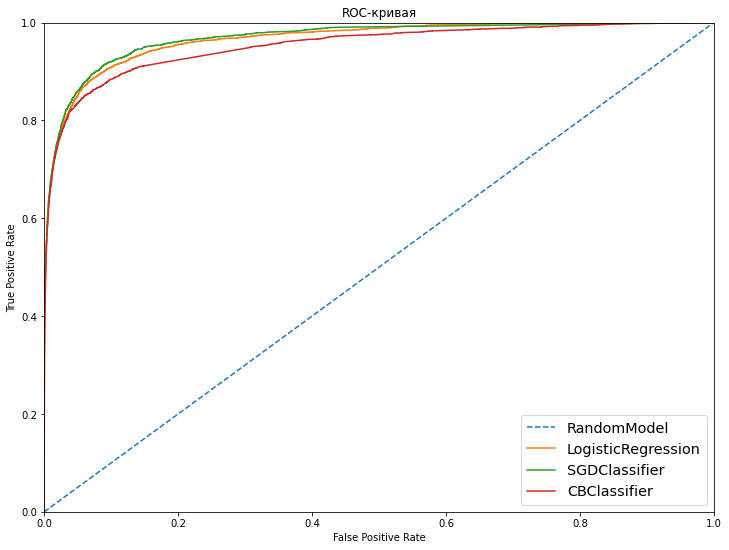

In [42]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

probabilities_test = lr_final.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = lr_final.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

probabilities_test = classificator_SGD.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator_SGD.predict(features_test)
plt.plot(fpr, tpr, label='SGDClassifier')
print('Метрики SGD Classifier')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

probabilities_test = classificator_cbc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator_cbc.predict(features_test)
plt.plot(fpr, tpr, label='CBClassifier')
print('Метрики CatBoostClassifier')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()



plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

## Выводы

Задача состояла в том, чтобы найти модель, способную отличать токсичные комментарии от обычных, и делать это со значением метрики F1, превышающей 0.75

Требуемого порога метрики на тестовых данных достигает __LogisticRegression__.

__! Примечание:__

- SGD Classifier имеет лучшую метрику ROC-AUC
- В том случае, если мы сделаем ресемплирование с уменьшением класса 0, и передадим такие данные в SGD и Catboost, то мы получим не улучшением метрики на тестовых данных, а ухудшение: 0.689766 и 0.726926 соответственно (код закомментирован ниже, далее это было проверено на моделях. Исполнение ноутбука в этом случае проходило, в среднем, за 8-12 минут за счет более быстрого обучения CatBoost'а)

In [43]:
# toxic_comments_train = df.iloc[target_train.index]

# target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
# target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

# target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
#                                                                     random_state=rs)
# target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

# features_train_downsample = df.iloc[target_train_downsample.index]
# features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
#                                                              target_train_downsample,
#                                                              random_state=rs)
# features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text']
#                                                    .values.astype('U'))

In [44]:
end_time = time.time()

_Total time, min_

In [45]:
(end_time - start_time) / 60

28.63283969958623